<a href="https://colab.research.google.com/github/JoungMinJu/lab_study/blob/main/%EB%AC%B8%EC%9E%A5%EB%B2%A1%ED%84%B0%EB%A5%BC_%EC%9D%B4%EC%9A%A9%ED%95%9C_%EC%B6%94%EC%B2%9C_%EC%8B%9C%EC%8A%A4%ED%85%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

각 문서를 문서벡터로 변환하는 방법은 이미 구현된 패키지인 Doc2Vec과 Sent2Vec과 같은 것을 사용하여 훈련하는 방법이 존재하지만

가장 간단한 방법은 문서 내에 존재하느 ㄴ단어벡터들의 평균을 구하는 것


In [1]:
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
from PIL import Image
from io import BytesIO
from nltk.tokenize import RegexpTokenizer
import nltk
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity

In [11]:
#데이터를 데이터프레임으로 로두하고 전체 문서의 수를 출력
df=pd.read_csv('data.csv')
print("전체 문서의 수 :",len(df))

전체 문서의 수 : 2382


In [12]:
df[:5]

,Unnamed: 0,Desc,Unnamed: 0.1,author,genre,image_link,rating,title
0,0,We know that power is shifting: From West to E...,0.0,Moisés Naím,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.63,The End of Power: From Boardrooms to Battlefie...
1,1,Following the success of The Accidental Billio...,1.0,Blake J. Harris,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.94,"Console Wars: Sega, Nintendo, and the Battle t..."
2,2,How to tap the power of social software and ne...,2.0,Chris Brogan,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.78,Trust Agents: Using the Web to Build Influence...
3,3,William J. Bernstein is an American financial ...,3.0,William J. Bernstein,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.20,The Four Pillars of Investing
4,4,Amazing book. And I joined Steve Jobs and many...,4.0,Akio Morita,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.05,Made in Japan: Akio Morita and Sony


In [23]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [24]:
#여기서는 문서벡터만들기위한 대상인 줄거리에 해당하는 "Desc 열이 중요하다
#해당 열에 있는 데이터에서 Word2Vec을 학습하여 얻기 위해서는 
#전처리와 토큰화 과정이 필요하다

#전처리 수행하고 clean라는 열에 저장할 것


def _removeNonAscii(s):
  return "".join(i for i in s if ord(i)<128)

def make_lower_case(text):
  return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_html(text):
  html_pattern=re.compile('<.*?>')
  return html_pattern.sub(r'',text)

def remove_puntuation(text):
  tokenizer=RegexpTokenizer(r'[a-zA-Z]+')
  text=tokenizer.tokenize(text)
  text= " ".join(text)
  return text

df['cleaned']=df['Desc'].apply(_removeNonAscii)
df['cleaned']=df['Desc'].apply(make_lower_case)
df['cleaned']=df['Desc'].apply(remove_stop_words)
df['cleaned']=df['Desc'].apply(remove_puntuation)
df['cleaned']=df['Desc'].apply(remove_html)

In [25]:
df['cleaned'][:5]

0    We know that power is shifting: From West to E...
1    Following the success of The Accidental Billio...
2    How to tap the power of social software and ne...
3    William J. Bernstein is an American financial ...
4    Amazing book. And I joined Steve Jobs and many...
Name: cleaned, dtype: object

In [27]:
#전처리 과정에서 빈 값이 생긴 행이 있다면, nan 값으로 변환한 후에 해당행을 제거해준다.

df['cleaned'].replace('', np.nan, inplace=True)
df = df[df['cleaned'].notna()]
print('전체 문서의 수 :',len(df))


전체 문서의 수 : 2382


In [28]:
#토큰화를 수행하여 corpus라는 리스트에 저장
#해당 리스트 corpus를 통해 Word2Vec을 훈련할 것입니다.
corpus=[]
for words in df['cleaned']:
  corpus.append(words.split())

사전 훈련된 워드 임베딩 사용하기

-Word2Vec을 처음부터 학습할 수도 있겠지만 데이터가 충분하지 않은 상황에서 사전 훈련된 워드 임베딩을 단어 벡터의 초기값으로 사용하여 성능을 높일 수 있다. 여기서는 사전 훈련된 Word2Vec을 다운받아서 이를 초기 단어 벡터값으로 사용할 것입니도


In [29]:
urllib.request.urlretrieve("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz", \
                           filename="GoogleNews-vectors-negative300.bin.gz")

('GoogleNews-vectors-negative300.bin.gz',
 <http.client.HTTPMessage at 0x7f0b1886a410>)

In [30]:
word2vec_model = Word2Vec(size = 300, window=5, min_count = 2, workers = -1)
word2vec_model.build_vocab(corpus)
word2vec_model.intersect_word2vec_format('GoogleNews-vectors-negative300.bin.gz', lockf=1.0, binary=True)
word2vec_model.train(corpus, total_examples = word2vec_model.corpus_count, epochs = 15)

(0, 0)

단어벡터의 평균 구하기

- 각 문서에 존재하는 단어들의 벡터값의 평균을 구하여 해당 문서의 벡터값을 연산

In [31]:
def vectors(document_list):
    document_embedding_list = []

    # 각 문서에 대해서
    for line in document_list:
        doc2vec = None
        count = 0
        for word in line.split():
            if word in word2vec_model.wv.vocab:
                count += 1
                # 해당 문서에 있는 모든 단어들의 벡터값을 더한다.
                if doc2vec is None:
                    doc2vec = word2vec_model[word]
                else:
                    doc2vec = doc2vec + word2vec_model[word]

        if doc2vec is not None:
            # 단어 벡터를 모두 더한 벡터의 값을 문서 길이로 나눠준다.
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)

    # 각 문서에 대한 문서 벡터 리스트를 리턴
    return document_embedding_list

In [32]:
document_embedding_list = vectors(df['cleaned'])
print('문서 벡터의 수 :',len(document_embedding_list))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


문서 벡터의 수 : 2381


추천시스템 구현하기
- 각 문서 베터 간의 코사인 유사도를 구한다.


In [33]:
cosine_similarities = cosine_similarity(document_embedding_list, document_embedding_list)
print('코사인 유사도 매트릭스의 크기 :',cosine_similarities.shape)

코사인 유사도 매트릭스의 크기 : (2381, 2381)


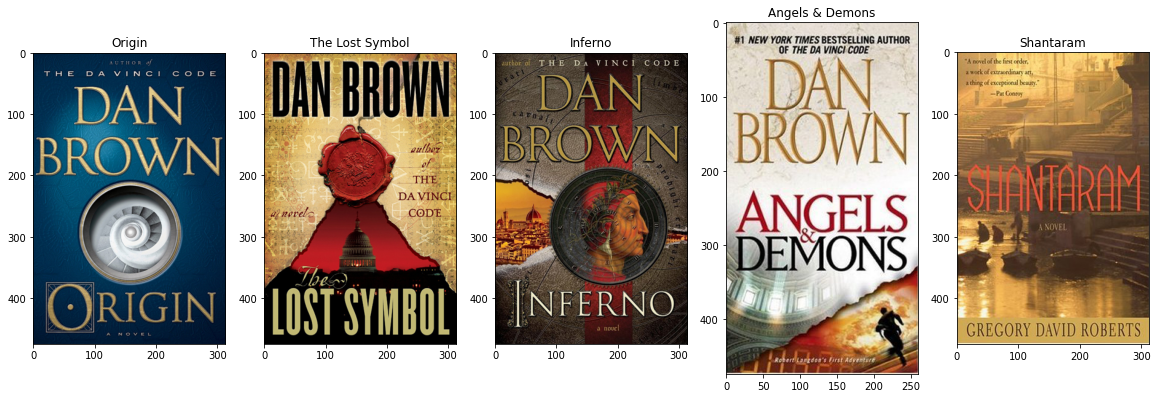

In [34]:
#이제 코사인 유사도 이용하여 가장 줄거리가 유사한 다섯개의 책을 찾아내는 함수를 만듬
def recommendations(title):
    books = df[['title', 'image_link']]

    # 책의 제목을 입력하면 해당 제목의 인덱스를 리턴받아 idx에 저장.
    indices = pd.Series(df.index, index = df['title']).drop_duplicates()    
    idx = indices[title]

    # 입력된 책과 줄거리(document embedding)가 유사한 책 5개 선정.
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]

    # 가장 유사한 책 5권의 인덱스
    book_indices = [i[0] for i in sim_scores]

    # 전체 데이터프레임에서 해당 인덱스의 행만 추출. 5개의 행을 가진다.
    recommend = books.iloc[book_indices].reset_index(drop=True)

    fig = plt.figure(figsize=(20, 30))

    # 데이터프레임으로부터 순차적으로 이미지를 출력
    for index, row in recommend.iterrows():
        response = requests.get(row['image_link'])
        img = Image.open(BytesIO(response.content))
        fig.add_subplot(1, 5, index + 1)
        plt.imshow(img)
        plt.title(row['title'])

    
#좋아하는 책 제목을 입력으로 넣으면 해당 책 줄거리 벡터(문서벡터)와 유사한 문서 벡터값을 가진 책들을 추천해준다.

recommendations('The Da Vinci Code')

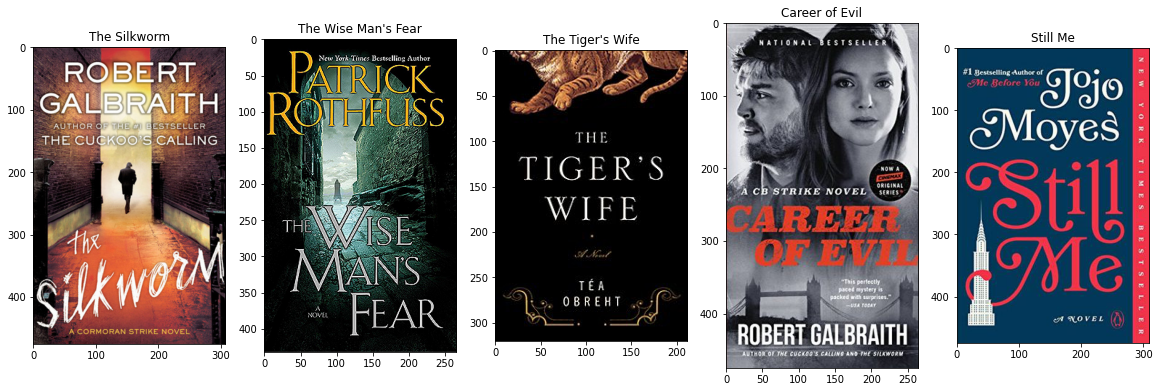

In [35]:
recommendations('The Murder of Roger Ackroyd')